In [94]:
import causalml
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseSLearner, BaseTLearner, BaseXLearner, BaseRLearner, BaseDRLearner

### 목차 
1. S-learner,T-learner,X-learner

    - S-learner
    - T-learner
    - X-learner

2. R -learner

### S-learner,T-learner,X-learner

📖 참고 논문
- 제목 : Meta-learners for Estimating Heterogeneous Treatment Effects using Machine Learning
- 저자 : S¨oren R. K¨unzela, Jasjeet S. Sekhona,b, Peter J. Bickela, and Bin Yua,c
- 출판 시기 : 2019

데이터 생성

In [96]:
np.random.seed(41)
# 사용 방법
num_features = 5
Y, X, W, tau, b, e = synthetic_data(mode=1, n=100, p=num_features) 

##### S-Learner
- 다른 모든 특성은 동일하나 처치 여부만 바뀌는 경우 적용 -> single
- ATE예측값은 처치가 적용되었을때의 값과 그렇지 않은 경우의 값의 평균의 차이

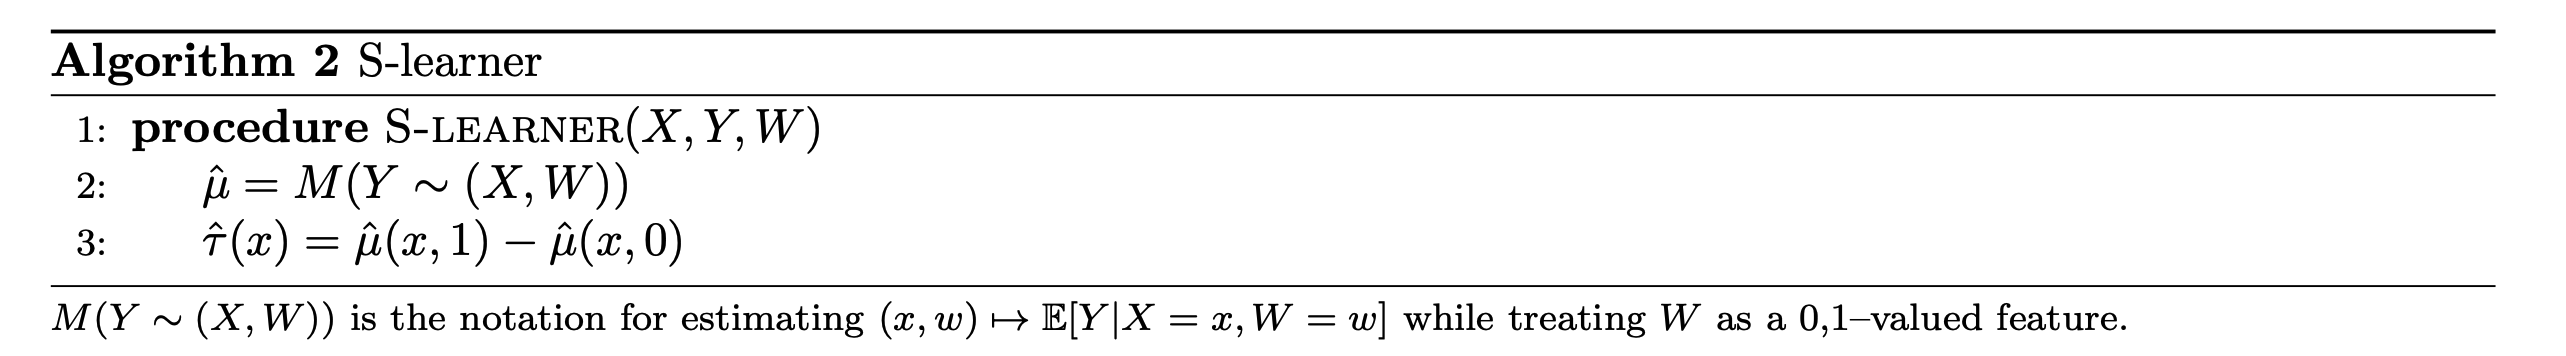

1. Base leaner(선형 회귀,랜덤 포레스트 등)로 통제 집단과 처치 집단의 반응을 같은 모델로 추정

In [97]:
model=LinearRegression()

# 1. X와 W를 합쳐서 학습
X_with_W = np.hstack([X, W.reshape(-1, 1)])
model.fit(X_with_W,Y)



,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


2. 각 추정치의 차이를 구하여 ATE 계산

In [98]:

# 2. W=0일 때의 예측 (통제 집단)
X_W0 = np.hstack([X, np.zeros((X.shape[0], 1))])
mu_0 = model.predict(X_W0)

# 3. W=1일 때의 예측(처치 집단)
X_W1 = np.hstack([X, np.ones((X.shape[0], 1))])
mu_1 = model.predict(X_W1)

ATE_manual_S=mu_1-mu_0



3. 직접 구현한 결과와 패키지 실행 결과 비교

- 동일하다

In [99]:

# 패키지를 이용
Lrt=BaseSLearner(learner=LinearRegression())
result = Lrt.estimate_ate(X,W,Y)

print('S Learner (ATE) by maual: ', round(ATE_manual_S[0],4))
print('S Learner (ATE) by package: ', round(result[0],4))


S Learner (ATE) by maual:  0.6731
S Learner (ATE) by package:  0.6731


##### T-learner

- 반응 함수를 각각 추정 -> TWo
- step 1: Base leaner(선형 회귀,랜덤 포레스트 등)로 통제 집단과 처치 집단의 반응을 각각 추정
- step 2: 각 추정치의 차이를 구함



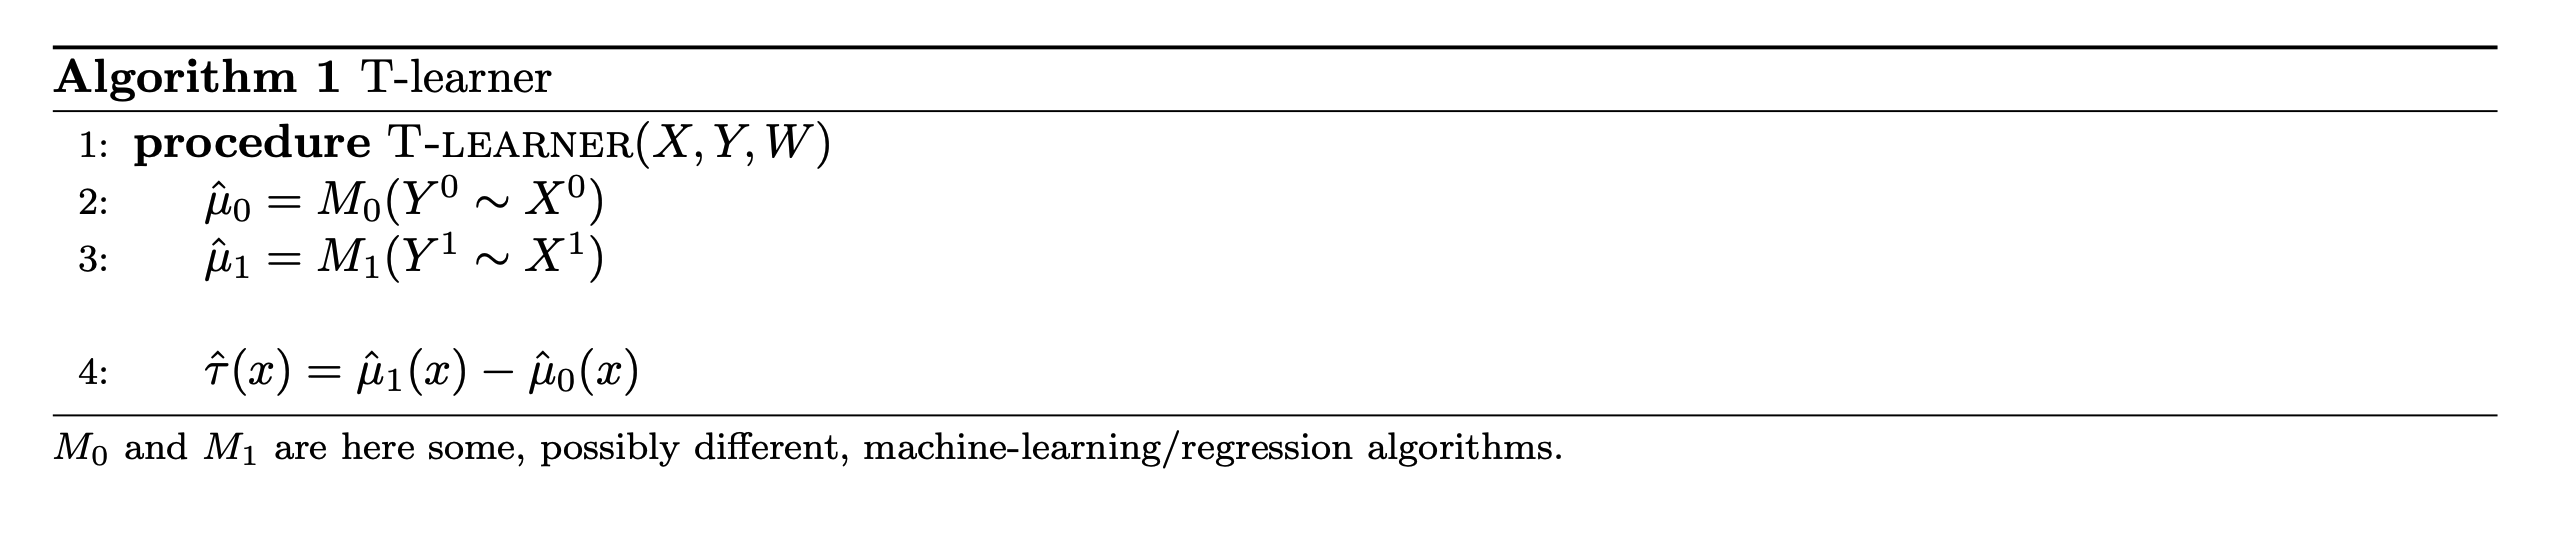

1. Base leaner(선형 회귀,랜덤 포레스트 등)로 통제 집단과 처치 집단의 반응 각각 추정

In [100]:
from xgboost import XGBRegressor
# 통제군
model_0 = XGBRegressor()
X_0 = X[W == 0]
Y_0 = Y[W == 0]
model_0.fit(X_0, Y_0)
mu_0=np.mean(model_0.predict(X))


# 실험군(처치군)
model_1 = LinearRegression()
X_1 = X[W == 1]
Y_1 = Y[W == 1]
model_1.fit(X_1, Y_1)
mu_1=np.mean(model_1.predict(X))


2. 각 추정치의 차이를 구하여 ATE 계산

In [101]:

# 개별 처치효과
ATE_manual_T=mu_1-mu_0


Lrt=BaseTLearner(learner=LinearRegression(),control_learner=XGBRegressor())
ate,ate_lower,ate_upper = Lrt.estimate_ate(X,W,Y)


3. 직접 구현한 결과와 패키지 실행 결과 비교

- 동일하다

In [102]:

print('T Learner (ATE) by maual: ', round(ATE_manual_T,4))
print('T Learner (ATE) by package: ', round(ate[0],4))

T Learner (ATE) by maual:  0.5401
T Learner (ATE) by package:  0.5401


##### X-Learner

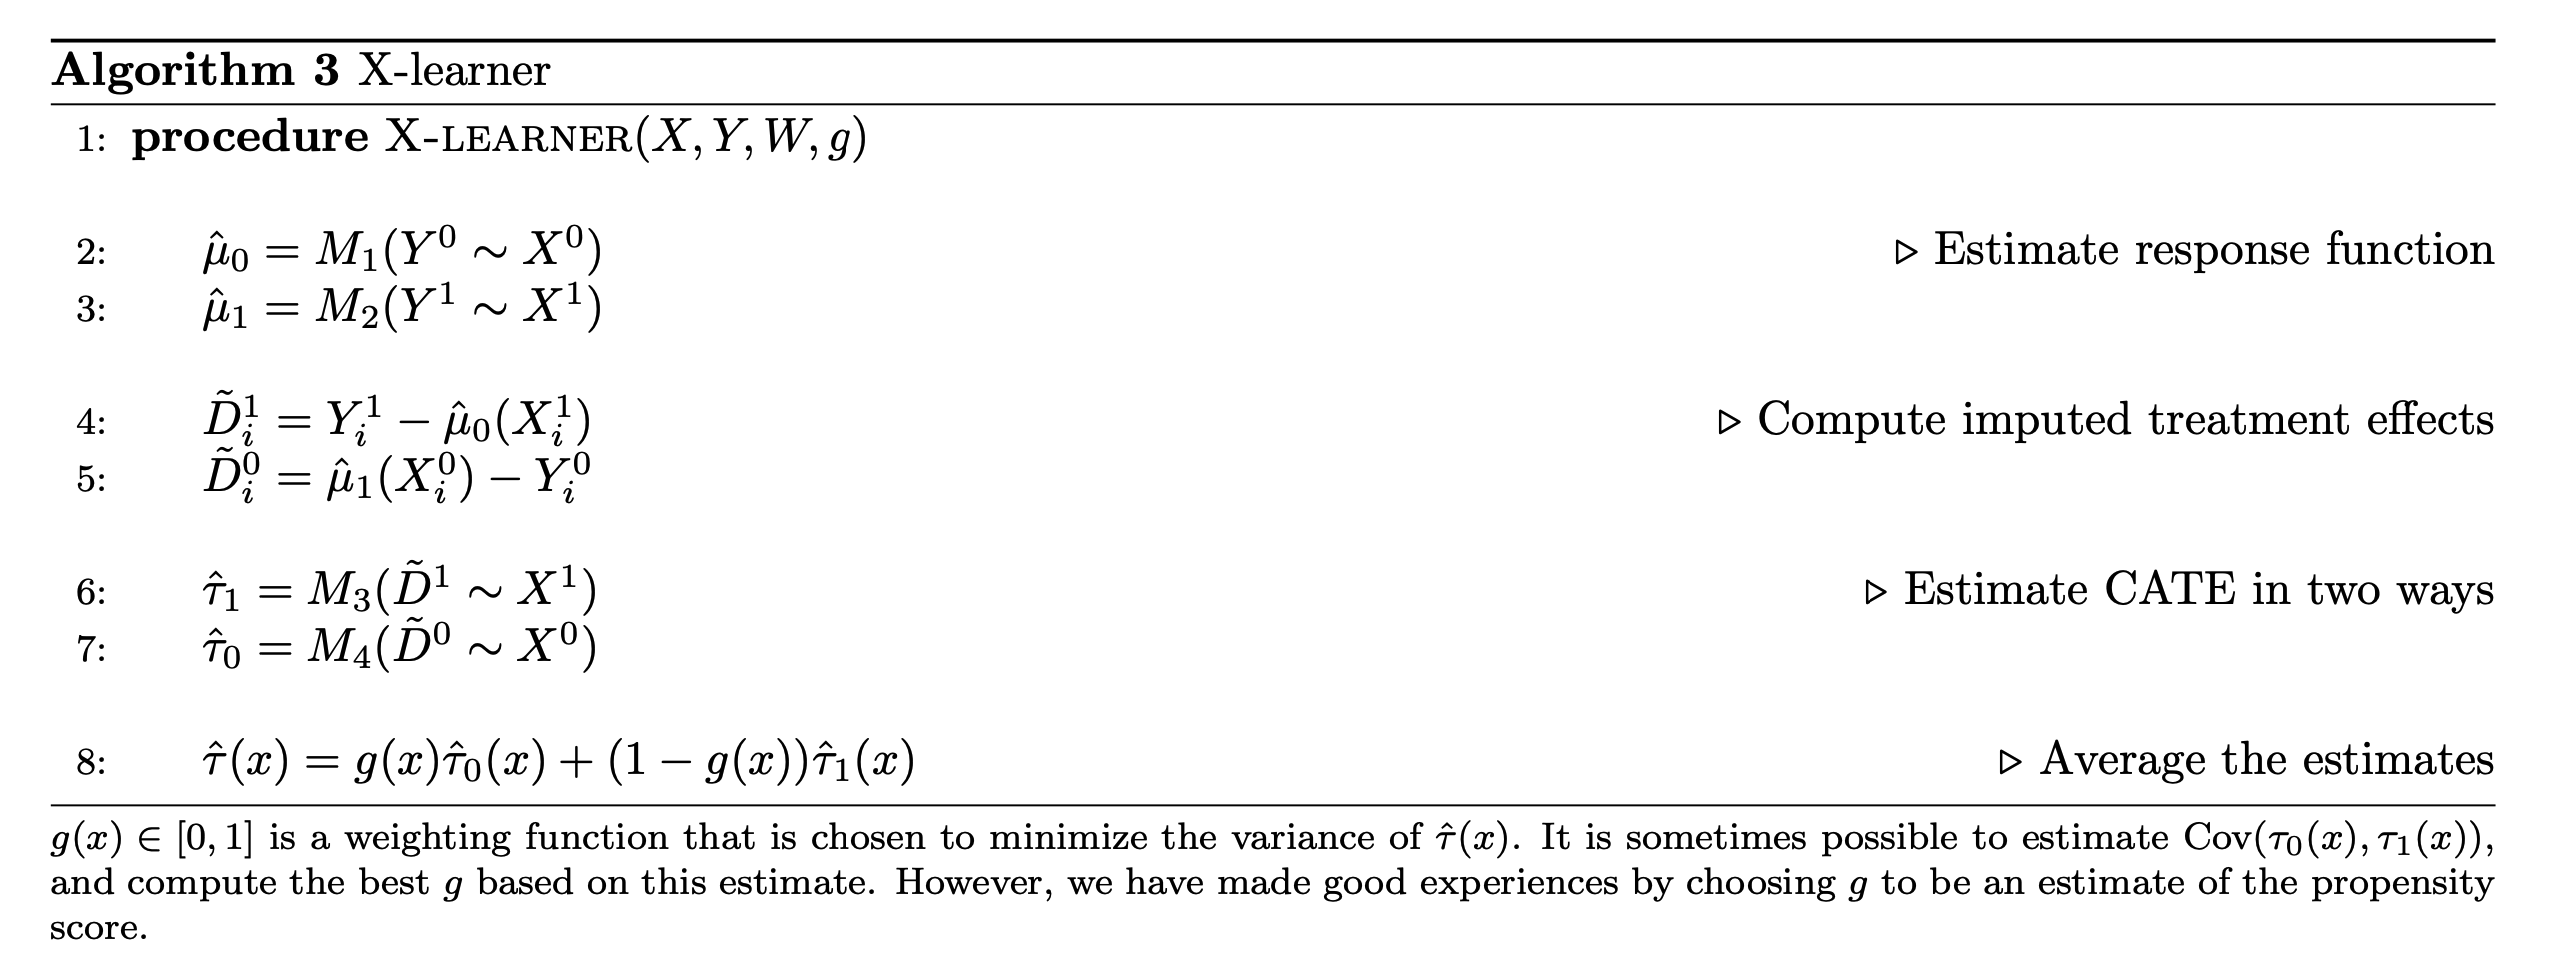

1. 반응 함수 추정

In [103]:
from xgboost import XGBRegressor
# 통제군
model_0 = XGBRegressor()
X_0 = X[W == 0]
Y_0 = Y[W == 0]
model_0.fit(X_0, Y_0)
mu_0=model_0.predict(X)
mu_hat_0=np.mean(mu_0)


# 실험군
model_1 = LinearRegression()
X_1 = X[W == 1]
Y_1 = Y[W == 1]
model_1.fit(X_1, Y_1)
mu_1=model_1.predict(X)
mu_hat_1=np.mean(mu_1)



2. 추정된 처치 효과 계산

In [104]:

D_1=Y_1-mu_0[W==1]
D_0=mu_0[W==0]-Y_0

# 개별 처치효과
model_2 = XGBRegressor()
model_2.fit(X_1,D_1)


model_3 = LinearRegression()
model_3.fit(X_0,D_0)



,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


3. CATE 계산

In [105]:

tau_1=model_2.predict(X)
tau_0=model_3.predict(X)



4. propensity score를 이용하여 ATE 계산

- $g(x)$는 $\hat \tau(x)$의 분산을 최소화하는 가중치 함수
- CATE의 공분산을 이용해서 구할 수 도 있으나 
- **propensity score를 이용해서 $g(x)$ 정의하는 것이 더 좋은 선택임**

In [106]:

# 평균처치효과 (ATE)


from sklearn.linear_model import LogisticRegression

# Step 4. Propensity score 모델 학습
propensity_model = LogisticRegression()
propensity_model.fit(X, W)

# g(x): 전체 관측치에 대한 propensity score
g_x = propensity_model.predict_proba(X)[:, 1]

tau_hat=g_x*tau_0+(1-g_x)*tau_1

ATE_hat_X = np.mean(tau_hat)


5. 직접 구현한 결과와 패키지 실행 결과 비교
- 각 결과가 다르게 나타나는 이유는 Xlearner 패키지의 경우 propensity score를 로지스틱 회귀로 구하지 않기 때문
- 대신 부트스트랩등 내부적으로 자체적으로 propensity score를 산출함
- 패키지를 이용해 예측한 결과를 평균내면 직접 구현한 결과와 동일하게 나옴

In [107]:
lrx = BaseXLearner(
    control_outcome_learner=XGBRegressor(),        # model_0
    treatment_outcome_learner=LinearRegression(),  # model_1
    control_effect_learner=LinearRegression(),     # model_3
    treatment_effect_learner=XGBRegressor()        # model_2
)

ate, ate_lb, ate_ub = lrx.estimate_ate(X, W, Y)


print('X Learner (ATE) by maual: ', round(ATE_hat_X,4))
print("X-Learner ATE :", round(ate[0], 4))

lrx.fit(X, W, Y)
tau_hat_lib = lrx.predict(X)
print("X-Learner ATE by package after predict :", round(np.mean(tau_hat_lib), 4))

X Learner (ATE) by maual:  0.282
X-Learner ATE : 0.6468
X-Learner ATE by package after predict : 0.6468


### R-Learner 





📖 참고 논문
- 제목 : Quasi-Oracle Estimation of Heterogeneous Treatment Effects
- 저자 : Xinkun Nie, tefan Wager
- 출판 시기 : 2020

**입력**  
- 훈련 데이터 $(X_i, Y_i, W_i)$, $i=1,\dots,n$  
- 교차 피팅 폴드 수 $Q$ (보통 5 또는 10)  
- 사용할 ML 기법 (예: Lasso, Boosting, NN 등)  

**출력**  
- 이질적 치료 효과 함수 $\hat\tau(x)$ (CATE 추정치)

데이터 생성

In [137]:
### Input 
np.random.seed(41)
# 사용 방법
num_features = 5
Y, X, T, tau, b, e = synthetic_data(mode=1, n=100, p=num_features) 



---

1단계: Nuisance 추정 (교차 피팅)  
1. 데이터를 $Q$개 폴드로 분할; 각 관측치 $i$의 폴드를 $q(i)$라 함.  
2. 각 폴드 $q$에 대하여:  
   - 나머지 $(Q-1)$개 폴드 데이터로  
     - 성향 점수 모델 $\hat e_{(-q)}(x)$ (e.g. 로지스틱 회귀)  
     - 결과 모델 $\hat m_{(-q)}(x)$ (e.g. 회귀) 
     - 참고 : $e^*(x) = P(W=1|X=x)$ , $m^*(x) = E(Y|X=x)$ 
     - 학습  
   - 폴드 $q$의 $X_i$에 대해 $\hat e_{(-q)}(X_i)$, $\hat m_{(-q)}(X_i)$ 예측  
3. 모든 폴드를 거쳐, 각 $i$에 대해 교차 피팅된 $\hat e^{(-q(i))}(X_i)$, $\hat m^{(-q(i))}(X_i)$ 확보

---


In [128]:
from sklearn.model_selection import KFold


# 폴드 수 설정
Q = 5
kf = KFold(n_splits=Q, shuffle=True, random_state=42)

# q(i) 저장용 배열
n = X.shape[0]
q = np.empty(n, dtype=int)  
 
# 각 관측치에 대한 out-of-fold 예측값을 저장할 배열
m_hat_oof = np.empty(n)
e_hat_oof = np.empty(n)




# 1. 데이터를 $Q$개 폴드로 분할; 각 관측치 $i$의 폴드를 $q(i)$라 함. 
for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):

    q[test_index] = fold_idx

    # 훈련 데이터와 테스트 데이터 분할

    X_train, X_test = X[train_index, :], X[test_index, :]
    W_train = T[train_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # 성향 점수 모델 (e.g., 로지스틱 회귀) 학습
    # 나머지 (Q-1)개 폴드 데이터(train_Data)로 학습
    propensity_model = LogisticRegression()
    propensity_model.fit(X_train, W_train)

    # g(x): 전체 관측치에 대한 propensity score
    e_q = propensity_model.predict_proba(X_test)[:, 1]
    e_hat_oof[test_index] = e_q

 

    # 결과 모델 
    model= LinearRegression()
   
    model.fit(X_test, Y_test)
    mu=model.predict(X_test)

    m_hat_oof[test_index] = mu
   



---

2단계: R-손실 최소화로 $\hat\tau$ 추정  
- **R-손실 함수**:  
  $\displaystyle \hat L_n(\tau) = \frac{1}{n}\sum_{i=1}^n \bigl[\{Y_i - \hat m^{(-q(i))}(X_i)\} - \{W_i - \hat e^{(-q(i))}(X_i)\}\,\tau(X_i)\bigr]^2$  
- **정규화 항** $\Lambda_n(\tau)$ (e.g. $L_1$ 페널티) 추가  
- **최적화 문제**:  
  $\displaystyle \hat\tau = \arg\min_{\tau}\bigl[\hat L_n(\tau) + \Lambda_n(\tau)\bigr]$  
- 하이퍼파라미터(정규화 강도 등)는 $\hat L_n$에 대한 교차 검증으로 선정

---

**결과**: 최적화로 얻은 $\hat\tau(x)$가 각 $x$에서의 CATE 추정치

In [133]:
from sklearn.linear_model import LassoCV


# Step 1에서 얻은 out-of-fold 예측값을 사용하여 잔차 계산 (전체 데이터셋에 대해)

residual_outcome = Y - m_hat_oof # 결과 잔차
residual_treatment = W - e_hat_oof # 처치 잔차



# Step 2 회귀를 위한 특징 행렬 생성

X_with_intercept = np.hstack((np.ones((n, 1)), X))


step2_features = residual_treatment[:, np.newaxis] * X_with_intercept 



# LassoCV는 표준 Lasso 목적 함수 (MSE + alpha * L1 norm)를 사용

lasso_tau_model = LassoCV(cv=5, random_state=42, max_iter=10000) # cv=5로 정규화 강도 튜닝

# 모델 학습
lasso_tau_model.fit(step2_features, residual_outcome)

tau_coeffs = lasso_tau_model.coef_

# tau(X) 함수의 절편과 기울기 분리
tau_intercept = tau_coeffs[0]
tau_slopes = tau_coeffs[1:]


# 위 계수를 사용하여 새로운 데이터 X_new에 대한 tau(X_new) 값을 예측하는 함수를 정의
def tau_hat_function_lasso(X_input):

    if X_input.ndim != 2 or X_input.shape[-1] != 5:
         raise ValueError(f"X_input은 (샘플 수, {5}) 형태의 2D 배열이어야 합니다.")

    # 추정된 절편과 기울기를 사용하여 예측
    return tau_intercept + X_input @ tau_slopes




In [134]:
from econml.dr import DRLearner
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV

# 각 단계별 모델 정의
propensity_model = LogisticRegression(max_iter=1000)
outcome_model = LinearRegression()
final_model = LassoCV(cv=5, random_state=42)

# DRLearner는 R-learner와 유사하게 작동하면서 model_final 인자를 사용 가능
rlearner_model = DRLearner(
    model_propensity=propensity_model,    # e(x)
    model_regression=outcome_model,       # mu(x)
    model_final=final_model,              # tau(x)
    featurizer=None,                      # phi(x): basis function
    random_state=42
)

# 학습
rlearner_model.fit(Y=Y, T=T, X=X)

# CATE 및 ATE 예측
tau_hat_econml = rlearner_model.effect(X)
ATE_hat_econml = np.mean(tau_hat_econml)

In [135]:
tau_hat_vals = tau_hat_function_lasso(X)
ATE_hat_manual = np.mean(tau_hat_vals)
print(f"ATE_hat_manual R-learner ATE 추정값: {ATE_hat_manual:.4f}")

ATE_hat_manual R-learner ATE 추정값: 0.5794


In [136]:
# ATE 추정 (effect 메서드의 평균)
ATE_hat_econml = np.mean(rlearner_model.effect(X))

print(f"econml R-learner 기반 ATE 추정값: {ATE_hat_econml:.4f}")

econml R-learner 기반 ATE 추정값: 0.8385



결과가 다르게 나온 이유

| 항목               | 직접 구현                                              | `econml.DRLearner`                                      |
|--------------------|--------------------------------------------------------|----------------------------------------------------------|
| **e(x) 추정**      | `LogisticRegression` + OOF 방식                       | 동일 (`propensity_model`로 학습)                        |
| **mu(x) 추정**     | `LinearRegression` + OOF 방식                         | 동일 (`regression_model`로 학습)                        |
| **잔차 계산 방식** | OOF 예측값 기반 잔차 계산                              | in-sample 또는 cross-fitting 기반 자동 처리             |
| **tau(x) 추정 방식** | 수동 구성: `tilde_W * X_with_intercept`에 회귀 적용 | sample weight + orthogonalization 자동 적용             |
| **기본 설계**      | 완전 수동 구성 (단순 선형 모델 기반)                  | doubly robust 및 orthogonal 설계 기반 최적화            |